# Code to recheck the triangle computer vision model

In [1]:
# First we create some framework as a testing base
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment


In [2]:
# Custom Dataset class
class TriangleDataset(Dataset):
    def __init__(self, dataset_path, labels, transform=None):
        self.dataset_path = dataset_path
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = os.path.join(self.dataset_path, label['file_name'])
        image = Image.open(img_path).convert('L')
        vertices = np.array(label['vertices']).flatten()

        if self.transform:
            image = self.transform(image)

        return image, vertices

In [3]:
def calculate_distances(predicted_vertices, real_vertices):
    """
    Calculate the distance from each predicted vertex to the nearest real vertex,
    ensuring that no two predicted vertices are paired with the same real vertex.

    Parameters:
    predicted_vertices (np.ndarray): 2D array of predicted vertices [N, 2].
    real_vertices (np.ndarray): 2D array of real vertices [M, 2].

    Returns:
    tuple: A tuple containing:
        - distances (np.ndarray): The distances of predicted vertices to their assigned real vertex.
        - assignment_indices (np.ndarray): The indices of the real vertices assigned to each predicted vertex.
    """
    # Calculate all pairwise distances
    distances = cdist(predicted_vertices, real_vertices)
    
    # Solve the assignment problem
    predicted_indices, real_indices = linear_sum_assignment(distances)
    
    # Calculate the minimum distances based on the optimal assignment
    min_distances = distances[predicted_indices, real_indices]
    
    return min_distances, real_indices

In [4]:
def plot_vertices(image, real_vertices, predicted_vertices, calculate_distances):
    """
    Plot the image, real vertices, predicted vertices, and lines between predicted vertices and their closest real vertices.
    Annotate the lines with the calculated distances and display the sum of distances.

    Parameters:
    image (torch.Tensor or np.ndarray): The image tensor or numpy array.
    real_vertices (np.ndarray): Real vertices as a numpy array.
    predicted_vertices (np.ndarray): Predicted vertices as a numpy array.
    calculate_distances (function): Function to calculate distances and closest indices.
    """
    # Ensure real and predicted vertices are in the correct shape
    real_vertices = real_vertices.reshape((-1, 2))
    predicted_vertices = predicted_vertices.reshape((-1, 2))

    # Convert the image tensor to a numpy array for plotting
    if isinstance(image, torch.Tensor):
        image_np = image.detach().cpu().numpy().squeeze()  # Adjusted for potential tensor characteristics
    elif isinstance(image, np.ndarray):
        image_np = image
    else:
        raise TypeError("Image must be a torch.Tensor or np.ndarray.")
    
    # Calculate distances and closest indices using the provided function
    min_distances, closest_indices = calculate_distances(predicted_vertices, real_vertices)
    
    # Calculate the sum of the distances
    sum_of_distances = np.sum(min_distances)
    
    # Create the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image_np, cmap='gray')
    plt.scatter(real_vertices[:, 0], real_vertices[:, 1], color='green', label='Real Vertices')
    plt.scatter(predicted_vertices[:, 0], predicted_vertices[:, 1], color='red', label='Predicted Vertices')
    
    # Draw lines and annotate distances
    for i, (dist, closest_idx) in enumerate(zip(min_distances, closest_indices)):
        pred_vertex = predicted_vertices[i]
        closest_real_vertex = real_vertices[closest_idx]
        plt.plot([pred_vertex[0], closest_real_vertex[0]], [pred_vertex[1], closest_real_vertex[1]], 'b--')
        mid_point = (pred_vertex + closest_real_vertex) / 2
        plt.text(mid_point[0], mid_point[1], f'{dist:.2f}', color='blue')
    
    # Display the sum of distances
    plt.title(f'Sum of Distances: {sum_of_distances:.2f}')
    plt.legend()
    plt.show()

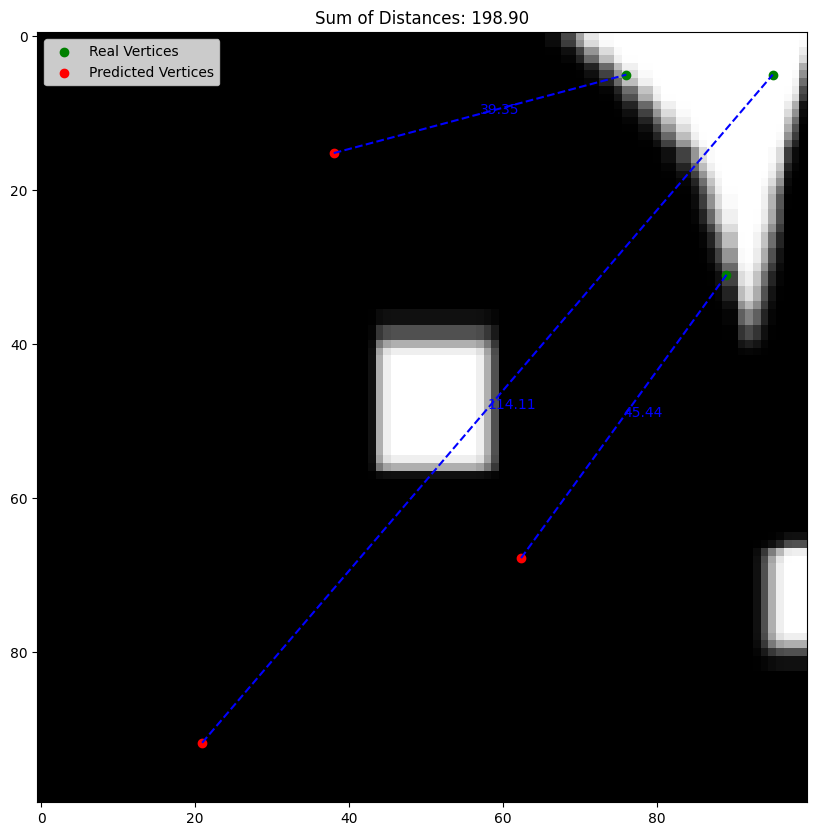

In [5]:
# Parameters
batch_size = 4
learning_rate = 0.001
num_epochs = 5


dataset_path = '/home/jay/AI/data/triangles_dataset/'
labels = np.load(os.path.join(dataset_path, 'labels.npy'), allow_pickle=True)

# Remember to resize images to 640x480 if not already
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize to match input size
    transforms.ToTensor(),
    # Add any additional transformations if needed
])

# Create the dataset and data loader
dataset = TriangleDataset(dataset_path, labels, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

image, real_vertices = dataset[np.random.randint(0,100)]  # This gets the first item; adjust the index as needed



# Create a vector of 6 random values between 0 and 100
predicted_vertices = np.random.rand(6) * 100

image, real_vertices, predicted_vertices



plot_vertices(image, real_vertices, predicted_vertices, calculate_distances)



In [6]:
def soft_assignment_loss(predicted_vertices, real_vertices):
    """
    Computes a loss that approximates minimizing the sum of the distances from each
    predicted vertex to its nearest real vertex, without ensuring unique assignments.
    
    Parameters:
    predicted_vertices (torch.Tensor): Predicted vertices with shape [batch_size, num_vertices, 2].
    real_vertices (torch.Tensor): Real vertices with shape [batch_size, num_vertices, 2].
    
    Returns:
    torch.Tensor: The computed loss.
    """
    batch_size, num_vertices, _ = predicted_vertices.size()
    
    # Expand dimensions to compute pairwise distances between all predicted and real vertices
    pred_exp = predicted_vertices.unsqueeze(2).expand(-1, -1, num_vertices, -1)
    real_exp = real_vertices.unsqueeze(1).expand(-1, num_vertices, -1, -1)
    
    # Compute Euclidean distances between all pairs of predicted and real vertices
    distances = torch.norm(pred_exp - real_exp, dim=3)
    
    # Find the minimum distance for each predicted vertex to a real vertex
    min_distances, _ = distances.min(dim=2)  # Resulting shape: [batch_size, num_vertices]
    
    # Sum these minimum distances and average over the batch
    loss = min_distances.sum(dim=1).mean()
    
    return loss

In [7]:
from model import EnhancedTriangleNet
# Instantiate the model
model = EnhancedTriangleNet()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
# Assuming calculate_distances() can be adapted for batch operation with PyTorch tensors
criterion = nn.MSELoss()  # This is a placeholder, you'll need a custom loss for the distance calculation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming `data_loader` is your DataLoader instance and `model` is your CNN model

for epoch in range(num_epochs):
    for images, true_vertices in data_loader:
        images = images.to(device)  # Move images to the configured device
        true_vertices = true_vertices.to(device).float()  # Convert true vertices to float and move to device

        # Forward pass
        predicted_vertices = model(images)
        
        # Compute loss
        loss = criterion(predicted_vertices, true_vertices)  # Now both tensors are float

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same